# Régression logistique multiclasse

_Pour ce Tp, hormis les bibliothèques numpy, sklearn et pyplot, nous avons utilisé $pandas$ et $seaborn$._

In [1]:
import numpy as np
from numpy import exp
from sklearn.datasets import load_digits
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
import seaborn as sn

<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


#### 1. Commencez par charger les données relatives à un problème de reconnaissance de chiffresmanuscrits :

In [2]:
n_class = 10
X,y = load_digits(n_class=n_class,return_X_y=True)

#### Visualisation du contenu de notre dataset

In [3]:
digits = load_digits()

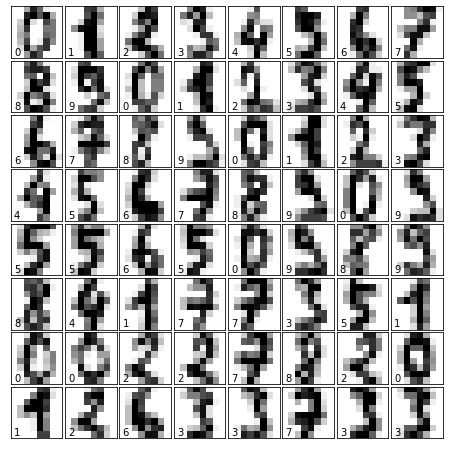

In [4]:
fig = plt.figure(figsize=(6, 6))
fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)

for i in range(64):
    ax = fig.add_subplot(8, 8, i + 1, xticks=[], yticks=[])
    ax.imshow(digits.images[i], cmap=plt.cm.binary, interpolation='nearest')
    ax.text(0, 7, str(y[i]))

### Commentaires: 
    
    Comme son nom l'indique, ce dataset comprend les données de chiffres. De 0 à 9, ce qui nous donne 10 classes.
A chaque classe, nous attribuons un label $y$ du nom de la classe(de 0 à 9).
    
Tous les chiffres ne sont pas repris avec la même fréquence. Nous pouvons l'observer sur l'image ci-haut.
    
    
Nous allons implémenter la $régression$ $logistique$  $multiclasse$ et l'appliquer sur ces données afin de retrouver le plus fidèlement posssible les différentes classes auxquelles elles appartiennent.

#### Normalisation des données

In [5]:
def normalisation(data):
    moy=data.mean()
    var=data.std()
    return (data-moy)/var
#
X = normalisation(X)

#### 2. Implémentez les fonctions permettant :

    
    ◦ de transformer les étiquettes des données en vecteurs de probabilités d’appartenance aux classes, à l’aide d’un encodage one-hot. Bien entendu, pour les données d’apprentissage, ces probabilités sont soit égales à 1 (pour la classe à laquelle appartient la donnée), soit égale à 0 (pour les autres classes).
    
    ◦ d’évaluer une fonction softmax étant donné un z = x.T@w
    
    ◦ d’estimer la probabilité d’appartenance d’un ensemble de données étant donné W.

#### _Fonction permettant de transformer les étiquettes des données en vecteurs de probabilités d’appartenance aux classes._

In [6]:
def oneHotEncodage(y,n_class):
# insérer votre code ici
    d = y.shape[0]
    y_one = np.zeros((d,n_class)) 
    y_one[np.arange(d),y] = 1
    return y_one
#
d=oneHotEncodage(y,n_class)
d

array([[1., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 1., 0.]])

#### _Fonction Softmax_

 _La fonction sotfmax est la probabilité de l’instance i d’appartenir à la classe k._


$$p_i,_k = p(y = λ_k|x_i) = \frac{exp(zi,j )}{\sum_l exp(zi,l)}$$
             
             
  

In [7]:
def softmax(z):
    z -= np.max(z) # computational trick for numerical stability : Normalisation
   # insérer votre code ici
    sm = (np.exp(z.T) / np.sum(np.exp(z), axis=1)).T
    return sm

#### _Fonction qui renvoie la probabilité d’appartenance d’un ensemble de données étant donné W ainsi que sa classe d'appartenance suivant la probabilité maximum._

In [8]:
def get_prob_pred(X,W):
    # insérer votre code ici
    w=W[:-1]
    b=W[-1]
    Z = X@w+b #X@W
    P = softmax(Z)# proba de tous les i
    probs = np.max(P,axis=1)
    preds = np.argmax(P,axis=1)
    p = np.sum(P,axis = 0) #p : Test somme de probabilité de toutes les classes doit être égale à 1.
    return probs , preds

#### 3. Implémentez maintenant une fonction qui calcule la fonction de coût et le gradient.

###### _Voici comment s'exprime la fonction coût  à minimiser:_ 



$$  min_w   \frac{1}{n}*\sum_i L(yi,y^ˆ_i) + \frac{\lambda}{2} \sum_{i,j} W^2_{i,j} $$


###### Voici son gradient : 

$$   \frac{-1}{n}*(X.T@ (y_{mat} - prob)) + lam*W $$


In [9]:
def get_loss_grad(W,X,y,lam,n_class): # VRAIE FONCTION
    y_mat = oneHotEncodage(y,n_class) # convert the integer class coding into a one-hot representation
    scores = X@W # compute raw class scores given our input and current weights
    prob = softmax(scores) # perform a softmax on these scores to get their probabilities
    # insérer votre code ici
    n=X.shape[0]
    loss =(-1/n) * np.sum(y_mat * np.log(prob)) + (lam/2)*np.sum(W*W)
    grad = (-1/n) * np.dot(X.T,(y_mat - prob)) + lam*W
    return loss, grad
#
W = np.random.rand(X.shape[1],n_class)
c, d = get_loss_grad(W,X,y,2,n_class)
d.shape

(64, 10)

#### 4. Implémentez une descente de gradient avec backtracking pour optimiser les paramètres W.

_Implémentons d'abord une fonction qui renvoie une matrice à laquelle on a ajoute la colonne du biais._

In [10]:
def matrice_augmente(data):
    y=data.shape[0]
    un=np.ones((y,1))
    return np.hstack((data,un))
#
Xa=matrice_augmente(X)  
#####
W = np.random.rand(X.shape[1],n_class)
c,d = get_loss_grad(W,X,y,2,n_class)
d.shape

(64, 10)

_Implémentons maintenant le fonction du backtrack._

In [11]:
def backtrack(fonct,X,c,sigma0,rho):
    sigma= sigma0
    loss,grad = fonct(W,X,y,lam,n_class)
    i=0
    a,b=fonct((W-sigma*grad),X,y,lam,n_class)
    while (a) < (loss + (c*sigma*(np.linalg.norm(-grad)))):
        sigma=rho*sigma
        loss,grad = fonct(W,X,y,lam,n_class)
        a,b=fonct((W-sigma*grad),X,y,lam,n_class)
        d=- grad
        crit = grad.T@d
        i=i+1
        #print("i",i)
        return sigma
#

_Implémentons maintenant l'algorithme de descente de gradient._

Cette fonction nous renvoie le minimum de la fonction ainsi que la liste de valeurs de la fonction coût pour chaque itération.

In [12]:
def gradient_descent(W0,X, Y,eps,backtrack,fonct): # VRAIE 
    k=0
    W=W0
    sigma=sigma0
    loss,grad = fonct(W,X,y,lam,n_class)
    loss_list=[loss]
    norme=np.linalg.norm(grad)
    #
    while norme > eps:
        d=-grad
        crit = grad.T@-grad
        sigma = backtrack(get_loss_grad,X,c,sigma0,rho)# Appel à backtracking
        W = W-sigma*grad
        loss,grad = fonct(W,X,y,lam,n_class)
        loss_list.append(loss)
        norme=np.linalg.norm(grad)      
        k=k+1
    #print(k)
    return W,loss_list

##### Exécution de la fonction de descente de gradient

_Les différents paramètres de fonctions $backtrack$ et $gradient-descent$_ sont:

In [13]:
sigma0 = 2
c=.2
rho = 0.2
W = np.random.rand(Xa.shape[1],n_class)
#
eps= 0.00001
#np.random.seed(0) # Pour ne pas modofier le point de départ
W0 = np.random.rand(Xa.shape[1],n_class) 
Y = y
lam = 0.01

rep,l = gradient_descent(W0,Xa, Y,eps,backtrack,get_loss_grad) # On doit avoir X augmentée. pour ajouter le biais à W
print("Les différentes valeurs de W pendant l'execution de la descente de gradient sont:\{}".format(rep))

Les différentes valeurs de W pendant l'execution de la descente de gradient sont:\[[-1.57257060e-03  4.22043889e-02 -1.85854717e-02  1.73177339e-03
  -7.21497054e-02  6.51279596e-03  3.01037350e-02 -3.67053873e-02
   3.04898108e-02  1.81938040e-02]
 [-1.14182975e-02  4.93559092e-03  2.18116995e-02  4.75874027e-02
  -8.33315289e-02  7.45008385e-02  9.15104177e-03 -3.13536118e-02
  -1.03275655e-02 -2.12113927e-02]
 [-3.29223743e-02 -1.08870765e-01  1.85118504e-01  2.08515722e-02
  -2.12786193e-01  4.61513848e-01 -2.56212189e-01  5.82928211e-02
  -7.22120989e-02 -4.24051640e-02]
 [ 1.19007157e-01  8.70840209e-03  8.21374493e-02  1.50679407e-01
  -4.23640709e-01 -2.03516600e-02 -7.42581802e-02  1.70965576e-01
  -1.98332223e-01  1.85466918e-01]
 [-2.24330036e-02 -5.39124214e-01  4.44333291e-03  4.24751752e-01
  -1.59528754e-01  1.42493562e-01 -6.96163811e-02  1.77091038e-01
   4.91273162e-02 -6.90718185e-03]
 [-2.41421510e-01  2.68665001e-01 -8.80010648e-02  2.17480832e-01
  -4.71108140e-01

#### 5. Évaluez l’erreur en classification sur les données d’apprentissage après entrainement.

Maintenant que notre $Régression$    $ logistique$  $multiclasse$ est mise en place, nous devons l'appliquer sur nos données.

Divisons- les en deux parties: une partie pour l'apprentissage, une autre pour le test.
Calculons ensuite la matrice de confusion et le taux de bonne classification.



#### _Division du dataset_

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25,random_state=0)

### Apprentissage

In [15]:
sigma0 = 2
c=.2
rho = 0.2
#
Xa=matrice_augmente(X_train)  
X = Xa
W = np.random.rand(Xa.shape[1],n_class)
#
eps= 0.00001
#np.random.seed(0) # Pour ne pas modofier le point de départ
W0 = np.random.rand(Xa.shape[1],n_class) 
y = y_train
lam = 0.01
#
rep,l = gradient_descent(W0,Xa,y,eps,backtrack,get_loss_grad)
rep

array([[ 2.48710801e-03,  4.56176020e-02, -2.37844466e-02,
         3.84752417e-03, -8.63379521e-02,  6.97307515e-04,
         3.37142148e-02, -3.08848259e-02,  2.89092492e-02,
         2.60325990e-02],
       [-8.59324157e-03,  1.33292592e-03,  2.92436146e-02,
         6.00519891e-02, -9.70756169e-02,  6.87936984e-02,
         8.45858210e-03, -2.65038477e-02, -2.07625593e-02,
        -1.46671355e-02],
       [-5.45746487e-02, -7.34590027e-02,  1.71605479e-01,
         2.01049196e-02, -1.63317948e-01,  4.79675246e-01,
        -2.69015687e-01,  1.93796519e-02, -8.08016525e-02,
        -4.92916301e-02],
       [ 1.38921775e-01, -3.59038628e-02,  7.33177218e-02,
         1.47626363e-01, -4.48764073e-01, -3.46183230e-02,
        -5.41950051e-03,  1.52086346e-01, -1.85756728e-01,
         1.98981507e-01],
       [-2.25060794e-02, -6.00944029e-01, -5.77144475e-02,
         3.96638113e-01, -1.88224675e-01,  1.61003273e-01,
        -1.05646838e-01,  2.04871654e-01,  1.27224100e-01,
         8.

#### _Probabilité d'appartenance à une classe après entrainement._

In [16]:
prob,pred= get_prob_pred(X_train,rep)
#
print("Valeurs de probabilités pour tous les individus d'appartenir à une classe",prob)

Valeurs de probabilités pour tous les individus d'appartenir à une classe [0.99281404 0.51922247 0.96678508 ... 0.96217861 0.9823207  0.95255266]


#### _Classification après entrainement._

In [17]:
print("Les classes prédites",pred)

Les classes prédites [2 8 9 ... 7 7 8]


### TEST

Testons le modèle avec le W obtenu de l'apprentissage.

In [18]:
probT,predT= get_prob_pred(X_test,rep)
#
print("Valeurs de probabilités pour tous les individus d'appartenir à une classe",probT)
print()
print("Les classes prédites",predT)

Valeurs de probabilités pour tous les individus d'appartenir à une classe [0.99173596 0.8545925  0.99700277 0.92261744 0.96340713 0.97418705
 0.95706034 0.86004669 0.83714463 0.94459857 0.99171445 0.83483357
 0.96348937 0.92349798 0.9530072  0.98214015 0.96859402 0.98958001
 0.99262557 0.91861503 0.89747767 0.7958268  0.79308211 0.94690528
 0.98596453 0.90345672 0.97875132 0.98608076 0.98014651 0.98636266
 0.98505261 0.99227219 0.98554465 0.49078465 0.95530101 0.97906894
 0.98231706 0.73418365 0.96602482 0.93077704 0.79141294 0.95370842
 0.93952798 0.98177373 0.44468808 0.92623877 0.74378232 0.68011576
 0.78233035 0.97367283 0.94098364 0.89683239 0.9582399  0.68566524
 0.97208675 0.9743128  0.5432138  0.73322495 0.97663304 0.99211109
 0.97212398 0.87439065 0.86322781 0.98449242 0.9028042  0.88109138
 0.51899215 0.93697661 0.79442988 0.71416908 0.90750318 0.95337969
 0.9322216  0.98247733 0.96059739 0.65159885 0.9457464  0.49432263
 0.94005331 0.99708579 0.89548363 0.82883081 0.95386901

#### _Matrice de confusion_

In [19]:
def matriceDeConfusion(data_app,data_test):
    ConfusionMatrix=np.zeros((n_class,n_class),int)
    for index, val in enumerate(data_app):
        j=data_test[index]
        ConfusionMatrix[val-1][j-1] +=1
    return ConfusionMatrix

#### Pour les données d'apprentissage

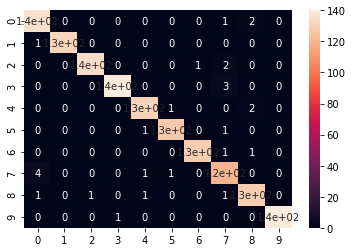

In [20]:
sn.heatmap(matriceDeConfusion(y_train,pred),annot=True)
plt.show()

#### Pour les données de test.

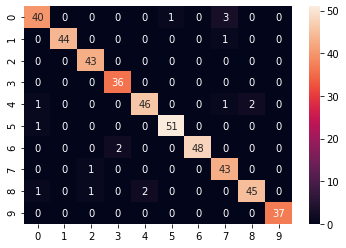

In [21]:
sn.heatmap(matriceDeConfusion(predT,y_test),annot=True)
plt.show()

#### _Taux d'erreur_

#### Pour les données d'apprentissage

In [22]:
taux = sum(pred == y_train)/(float(len(y_train)))
print("Taux de bonne classifiaction",taux)
print()
print("Taux d'erreur est ",1-taux)


Taux de bonne classifiaction 0.9792130660727543

Taux d'erreur est  0.020786933927245732
0.9792130660727543


#### Pour les données de test.

In [23]:
taux = sum(predT == y_test)/(float(len(y_test)))
print("Taux de bonne classifiaction",taux)
print()
print("Taux d'erreur est ",1-taux)

Taux de bonne classifiaction 0.9622222222222222

Taux d'erreur est  0.0377777777777778


### Commentaire:
    
    En tenant compte du taux d'erreur notre modèle est relativement bon. 
    
    Les taux d'erreurs en apprentissage et en test sont très faible. 

 _Evaluation du Taux de bonne classification en fonction du paramètre $lam$._

#### Pour les données d'apprentissage

In [24]:
sigma0 = 2
c=.2
rho = 0.2
#
Xa=matrice_augmente(X_train)  
X = Xa
W = np.random.rand(Xa.shape[1],n_class)
#
eps= 0.00001
#np.random.seed(0) # Pour ne pas modofier le point de départ
W0 = np.random.rand(Xa.shape[1],n_class) 
y = y_train
#

lam = 0.01
rep1,l = gradient_descent(W0,Xa,Y,eps,backtrack,get_loss_grad) 
probT,pred1= get_prob_pred(X_train,rep1)
taux1 = (sum(pred1 == y_train)/(float(len(y_train))))
 #
lam = 0.1
rep2,l = gradient_descent(W0,Xa,Y,eps,backtrack,get_loss_grad) 
probT,pred2= get_prob_pred(X_train,rep2)
taux2 = (sum(pred2 == y_train)/(float(len(y_train))))
#
lam = 0.5
rep3,l = gradient_descent(W0,Xa,Y,eps,backtrack,get_loss_grad)
probT,pred3= get_prob_pred(X_train,rep3)
taux3 = (sum(pred3 == y_train)/(float(len(y_train))))
#
lam = 0.8
rep4,l = gradient_descent(W0,Xa,Y,eps,backtrack,get_loss_grad)
probT,pred4= get_prob_pred(X_train,rep4)
taux4 = (sum(pred4 == y_train)/(float(len(y_train))))
#          
    
tauxLam = [taux1,taux2,taux3,taux4]

Le taux de bonne classification en fonction de lam  est  [0.9792130660727543, 0.947290274684484, 0.9220489977728286, 0.9101707498144024]


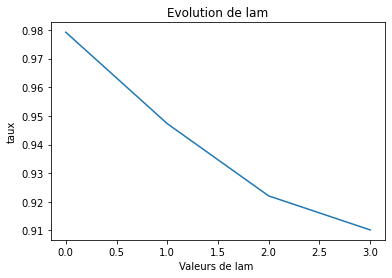

In [25]:
print("Le taux de bonne classification en fonction de lam  est ",tauxLam)
###
plt.plot(tauxLam)
plt.title("Evolution de lam")
plt.xlabel('Valeurs de lam ')
plt.ylabel('taux')
plt.show()

#### Pour les données de Test

Le taux de bonne classification en fonction de lam  est  [0.9622222222222222, 0.9288888888888889, 0.9, 0.8888888888888888]


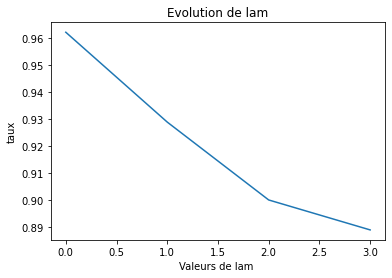

In [28]:
probT,predT1= get_prob_pred(X_test,rep1)
taux1 = sum(predT1 == y_test)/(float(len(y_test)))
#
probT,predT2= get_prob_pred(X_test,rep2)
taux2 = sum(predT2 == y_test)/(float(len(y_test)))
#
probT,predT3= get_prob_pred(X_test,rep3)
taux3 = sum(predT3 == y_test)/(float(len(y_test)))
#
probT,predT4= get_prob_pred(X_test,rep4)
taux4 = sum(predT4 == y_test)/(float(len(y_test)))
#
tauxLam = [taux1,taux2,taux3,taux4]
#
print("Le taux de bonne classification en fonction de lam  est ",tauxLam)
###
plt.plot(tauxLam)
plt.title("Evolution de lam")
plt.xlabel('Valeurs de lam ')
plt.ylabel('taux')
plt.show()

### Commentaire:
    
    Plus grand devient le taux de régularisation 'lam', moins bon est le taux de bonne classification.
    
La régularisationle empêche le modèle de s'adapter de manière optimale aux données d'apprentissage.  Plus  le taux de régularisation devient grand, plus on s'éloigne du vrai minimum de la fonction.

Cependant, le taux de régularisation ne devrait pas être trop petit car il nous conduira à un sur apprentissage. Nous pouvons observer la proportion de taux d'apprentissage par rapport au taux de test dans les figures ci-dessus.

Plus le taux diminue en apprentissage, plus c'est le cas pour test.

#### 6. Affichez l’évolution de la fonction objective après chaque itération.

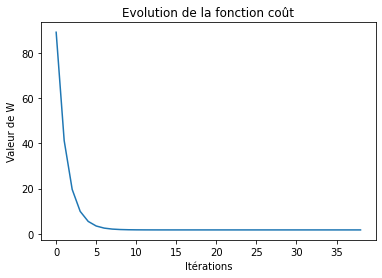

In [29]:
plt.plot(l)
plt.title("Evolution de la fonction coût")
plt.xlabel('Itérations')
plt.ylabel('Valeur de W')
plt.show()

In [30]:
print("Evolution de W après les itérations",l)

Evolution de W après les itérations [89.09214923314842, 41.194113973356735, 19.606483132614912, 9.896474603909775, 5.465090667035932, 3.435072002219761, 2.5033525239747325, 2.075105249960733, 1.8781038798047593, 1.7874183127665302, 1.745651654120848, 1.7264081741238555, 1.7175385470831128, 1.713449408718218, 1.7115635734250896, 1.7106936957011154, 1.7102923178594227, 1.7101070795335434, 1.7100215612037297, 1.7099820710578866, 1.7099638280222331, 1.7099553976274335, 1.7099514997309104, 1.7099496965997178, 1.709948861870725, 1.7099484751512333, 1.7099482957965306, 1.7099482125151995, 1.7099481737826348, 1.7099481557354805, 1.7099481473063693, 1.7099481433582961, 1.7099481415024638, 1.7099481406264052, 1.7099481402106977, 1.7099481400122238, 1.7099481399167697, 1.7099481398704737, 1.7099481398478007]


### Commentaire:
    
    Nous pouvons observer comment la fonction baisse au fil des itérations.

### Comparaison avec la fonction de Sklearn pour la régression logistique multiclasse.

In [31]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25,random_state=0)
#
model = LogisticRegression(multi_class='multinomial',solver='lbfgs',max_iter = 500).fit(X_train,y_train)
prediction=model.predict(X_test)
t = f1_score(y_test,prediction,average='micro')
print("Score: ",t)

Score:  0.9673590504451038


### Commentaires:



Avec un taux de régularisation de $0.01$, nous trouvons pratiquement le même taux de bonne classification que la fonction de sklearn.

sklearn utilise par défaut, la pénalité $l2$ c’est-à-dire que l’on ajoute une pénalité équivalente au carré de la taille des W contrairement à la pénalité $l1$ qui équivaut à la valeur absolue de la taille des W.  
    